### Import libraries that we use

In [26]:
import pandas as pd
import xml.etree.ElementTree as ET
import plotly.express as px
import os
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import scipy
import numpy as np
import scipy.fftpack
from itertools import islice
from scipy import signal
import statistics as stat

### Set a list of days that script tries to read from directory with results

In [2]:
num_of_days = 480
step = 20
current_day_list = 0
file_names_list = []
days_to_iterate = current_day_list + num_of_days
        
while current_day_list < days_to_iterate+step:
    file_names_list.append(current_day_list)
    current_day_list += step

### Read data from directories
Firstly we should to set a variable with a path to directory with results and a number of samples in this folder.

This script parse data only for Eurostat agent and for environment. Other agents can be added the similar way.

In [ ]:
number_of_samples = 1499
root_path = '/data/home/nsov/eurace/original/reproduce_results/'

last_day = max(file_names_list)
large_dataframe = pd.DataFrame()

for num in range(1, number_of_samples + 1):
    case_name = 'test_div_' + str(num)
    dir_name = case_name# + '_' + str(num)
    current_dir = root_path + dir_name
    try:
        df = pd.DataFrame()

        for file in file_names_list: 
            if file == 0:
                xml_data = open(current_dir + '/{}.xml'.format('0_initial'), 'r').read()  # Read file
            else:
                xml_data = open(current_dir + '/{}.xml'.format(file), 'r').read()  # Read file
            root = ET.XML(xml_data)  # Parse XML

            data = []
            cols = []
            names = []
            for i, child in enumerate(root):
                try:
                    names.append(child.find('name').text)
                except:
                    pass
                if child.tag == 'xagent':
                    if child.find('name').text == 'Eurostat':
                        data.append([subchild.text for subchild in child]) #Eurostat variables for this day
                        data[0].extend(run_info) # Attach info about environment
                        data[0].append(itno) # Attach number of iteration
                        if file == last_day: #Update columns names the same way as lists above
                            cols = [subchild.tag for subchild in child]
                            cols.extend(run_info_tags)
                            cols.append('itno')
                elif child.tag == 'environment': # save data about environment
                    if file == 0: #We need to extract this information only once
                        run_info = [subchild.text for subchild in child]
                        run_info_tags = [subchild.tag for subchild in child]
                elif child.tag == 'itno': # save iteration number
                    itno = child.text
            df2 = pd.DataFrame(data)
            df = pd.concat([df, df2], ignore_index=True)
            if file == last_day:
                df.columns = cols  # Update column names
        df['run_number'] = [num] * len(df)
        large_dataframe = pd.concat([large_dataframe, df])
        if (num % 100) == 0:
            print('Done for ' + dir_name)
    except:
        print('Error for ' + dir_name)

Done for test_div_100
Done for test_div_200
Done for test_div_300
Done for test_div_400
Done for test_div_500
Done for test_div_600
Done for test_div_700
Done for test_div_800
Done for test_div_900
Done for test_div_1000
Done for test_div_1100
Done for test_div_1200
Done for test_div_1300


### Move parameters that we will use to numeric values

In [6]:
large_dataframe.const_dividend_earnings_ratio = pd.to_numeric(large_dataframe.const_dividend_earnings_ratio)
large_dataframe.gov_policy_swith_quantitative_easing = pd.to_numeric(large_dataframe.gov_policy_swith_quantitative_easing)
large_dataframe.ecb_interest_rate = pd.to_numeric(large_dataframe.ecb_interest_rate)
large_dataframe.const_income_tax_rate = pd.to_numeric(large_dataframe.const_income_tax_rate)
large_dataframe.igfirm_exogenous_innovation_probability = pd.to_numeric(large_dataframe.igfirm_exogenous_innovation_probability)
large_dataframe.unemployment_rate = pd.to_numeric(large_dataframe.unemployment_rate)
large_dataframe.gov_policy_gdp_fraction_investment = pd.to_numeric(large_dataframe.gov_policy_gdp_fraction_investment)
large_dataframe.itno = pd.to_numeric(large_dataframe.itno)
large_dataframe.gdp = pd.to_numeric(large_dataframe.gdp)

**This block shows how changed an output curve of unemployment for different dividends payout ratio settings.**

This part of code is not important for OFAT analysis. It can be used for observing how the model acts on early stages.

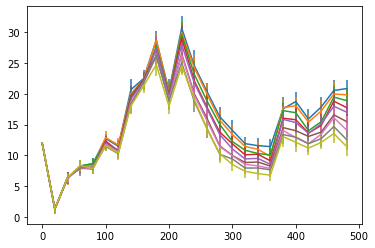

In [8]:
for div in [i/10 for i in range(1, 10, 1)]:
    plt.errorbar([i*20 for i in range(25)],large_dataframe.loc[(large_dataframe.gov_policy_swith_quantitative_easing == 0)
                       & (large_dataframe.ecb_interest_rate == 0.05) & (large_dataframe.const_income_tax_rate == 0.05)
                       & (large_dataframe.const_dividend_earnings_ratio == div) & (large_dataframe.gov_policy_gdp_fraction_investment == 0)
                       & (large_dataframe.igfirm_exogenous_innovation_probability == 5)].groupby('itno').unemployment_rate.mean(),
                large_dataframe.loc[(large_dataframe.gov_policy_swith_quantitative_easing == 0)
                       & (large_dataframe.ecb_interest_rate == 0.05) & (large_dataframe.const_income_tax_rate == 0.05)
                       & (large_dataframe.const_dividend_earnings_ratio == div) & (large_dataframe.gov_policy_gdp_fraction_investment == 0)
                       & (large_dataframe.igfirm_exogenous_innovation_probability == 5)].groupby('itno').unemployment_rate.std())

### Build OFAT plots

This block of code shows OFAT curve and std bands.

**Important:** Std bands are counted as std of all daily values. Thus, these bands are large due to high volatility of the output. If you want to see std of mean values of experiments, then use next block.

This block of code does not work automatically for all variables. Now it's manual.
You need to set ```ofat_var``` to a parameter you want to examine and list other variables you want to keep fixed in ```y_base``` setting.

In [13]:
ofat_variables = ['const_dividend_earnings_ratio',
                 'const_income_tax_rate',
                 'ecb_interest_rate',
                 'gov_policy_swith_quantitative_easing']

ofat_var = 'ecb_interest_rate'

list_of_lines_ofat = []
x = np.sort(large_dataframe[ofat_var].unique())
y_base = large_dataframe.loc[(large_dataframe.gov_policy_swith_quantitative_easing == 0)
                       &  (large_dataframe.const_dividend_earnings_ratio == 0.7) &  (large_dataframe.const_income_tax_rate == 0.05)
                       & (large_dataframe.gov_policy_gdp_fraction_investment == 0) & (large_dataframe.igfirm_exogenous_innovation_probability == 5)
                       &  (large_dataframe.itno >= 240)]
gdp_diff = y_base.groupby('run_number').gdp.diff()
y_base['gdp_diff'] = gdp_diff/y_base['gdp']
y_base = y_base.groupby(ofat_var).gdp_diff

y = y_base.mean()
y_std = y_base.std()
y_err_up = y + y_std
y_err_down = y - y_std
list_of_lines_ofat.append(
    go.Scatter(
        name=str(ofat_var),
        x=x,
        y=y,
        mode='lines'
    ))
list_of_lines_ofat.append(
    go.Scatter(
        name=str(ofat_var) + ' (std)',
        x=np.append(x,x[::-1]), # x, then x reversed
        y=np.append(y_err_up,y_err_down[::-1]),
        fill='toself',
        fillcolor='rgba(0,0,150,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=True
    ))

fig = go.Figure(list_of_lines_ofat)
fig.update_layout(xaxis_title=ofat_var,
                 yaxis_title='Unemployment')
fig.write_html(str(ofat_var)+"_ofat_qe0.html")

/opt/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Build OFAT plots

This block of code shows OFAT curve and std bands.

**Important:** Std bands are counted as std of mean values of experiments. If you want to see std of all daily values, then use previous block.

This block of code does not work automatically for all variables. Now it's manual.
You need to set ```ofat_var``` to a parameter you want to examine and list other variables you want to keep fixed in ```y_base``` setting.

In [23]:
ofat_variables = ['const_dividend_earnings_ratio',
                 'const_income_tax_rate',
                 'ecb_interest_rate',
                 'gov_policy_swith_quantitative_easing']

ofat_var = 'const_income_tax_rate'

n = 12 #Number of month in observed experiment

list_of_lines_ofat = []
x = np.sort(large_dataframe[ofat_var].unique())
y_base = large_dataframe.loc[(large_dataframe.gov_policy_swith_quantitative_easing == 0)
                       &  (large_dataframe.const_dividend_earnings_ratio == 0.7) &  (large_dataframe.ecb_interest_rate == 0.05)
                       & (large_dataframe.gov_policy_gdp_fraction_investment == 0) & (large_dataframe.igfirm_exogenous_innovation_probability == 5)
                       &  (large_dataframe.itno >= 240)]
gdp_groups = y_base.groupby('run_number').gdp
gdp_diff = gdp_groups.diff()
y_base['gdp_diff'] = gdp_diff/y_base['gdp']
y_base = y_base.groupby(ofat_var).gdp_diff

y = y_base.mean()
# y_std = y_base.std()
y_std_list = []

for x_add, y_add in y_base:
    group = y_add.dropna()
    group_new = [stat.mean(list(group)[i:i + n]) for i in range(0, len(group), n)]
    y_std_list.append(stat.stdev(group_new))

y_std = pd.Series(y_std_list)
y= y.reset_index(drop = True)

y_err_up = y + y_std
y_err_down = y - y_std
list_of_lines_ofat.append(
    go.Scatter(
        name=str(ofat_var),
        x=x,
        y=y,
        mode='lines'
    ))
list_of_lines_ofat.append(
    go.Scatter(
        name=str(ofat_var) + ' (std)',
        x=np.append(x,x[::-1]), # x, then x reversed
        y=np.append(y_err_up,y_err_down[::-1]),
        fill='toself',
        fillcolor='rgba(0,0,150,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=True
    ))

# for x, y in y_base:
#     group = y.dropna()
    

fig = go.Figure(list_of_lines_ofat)
fig.update_layout(xaxis_title=ofat_var,
                 yaxis_title='Unemployment')
fig.write_html(str(ofat_var)+"_ofat_qe0.html")

/opt/Anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Save/Load Dataframes

In [178]:
large_dataframe.to_csv('ofat_trial_20_samples_wide_ranges_qe_0.csv')

In [3]:
large_dataframe = pd.read_csv('ofat_trial_20_samples_wide_ranges_qe_0.csv', index_col= 'Unnamed: 0')  